In [23]:
import pandas as pd
from urllib.request import urlretrieve
import os

In [2]:
urls = ['https://www.abs.gov.au/statistics/people/population/regional-population-age-and-sex/2021/32350DS0001_2021.xlsx', \
       'https://www.abs.gov.au/statistics/people/population/deaths-australia/2020/33020DO005_2020.xlsx', \
       'https://www.abs.gov.au/statistics/people/education/schools/2021/Table%2035b%20Counts%20of%20all%20Schools%2C%202010-2021.xlsx']

names = ['age_sex', 'pop_deaths', 'education']

In [3]:
# Setting PATH for downloads

output_relative_dir = '../data/raw/'
if not os.path.exists(output_relative_dir):
    os.makedirs(output_relative_dir)
    
# Creates abs_data folder within raw_data
if not os.path.exists(output_relative_dir + 'abs_data'):
    os.makedirs(output_relative_dir + 'abs_data')
    
abs_output_dir = output_relative_dir + 'abs_data'

In [4]:
# Downloading the .xlsx files

i = 0
for url in urls:
    output_dir = f"{abs_output_dir}/{names[i]}.xlsx"
    print(f'File {i+1} started.')
    urlretrieve(url, output_dir)
    print(f'File {i+1} finished.')
    i += 1

File 1 started.
File 1 finished.
File 2 started.
File 2 finished.
File 3 started.
File 3 finished.


## Reading in pop_deaths -

- `pop_deaths` contains information about the estimated resident population, recorded deaths and standardised death rate across each LGA
- Sheet 2 contains VIC info

In [5]:
df = pd.read_excel('../data/raw/abs_data/pop_deaths.xlsx', sheet_name = 2, skiprows = 4, header = [0,1], nrows = 129)[1:]
df = df.drop([(y, 'Standardised death rate.1') for y in range(2012, 2020)], axis=1)
df = df.drop([(y, 'Standardised death rate') for y in range(2012, 2021)], axis=1)
df.columns = [('LGA Code'), ('LGA Name')] + [','.join([str(c) for c in x]) for x in df.columns[2:]]
df2 = df.melt(id_vars=["LGA Code", "LGA Name"])
df2 = df2.dropna()
df2['value'] = df2.value.astype('int')
df2[['year','var']] = df2['variable'].str.split(',').tolist()
df2 = df2.sort_values('year')

In [6]:
df2.tail()

,LGA Code,LGA Name,variable,value,year,var
1446,25490,Moyne (S),"2020,Estimated resident population",17027,2020,Estimated resident population
1447,25620,Murrindindi (S),"2020,Estimated resident population",14661,2020,Estimated resident population
1448,25710,Nillumbik (S),"2020,Estimated resident population",65219,2020,Estimated resident population
1470,27630,Yarriambiack (S),"2020,Estimated resident population",6588,2020,Estimated resident population
1558,29399,Unincorporated Vic,"2020,Deaths",0,2020,Deaths


# How to make graph less noisy?

- Could sample 30-50 rows, show 3 visualisations + map 
- Could only select areas (suburbs) of interest
- Could show upper, middle and lower areas + map

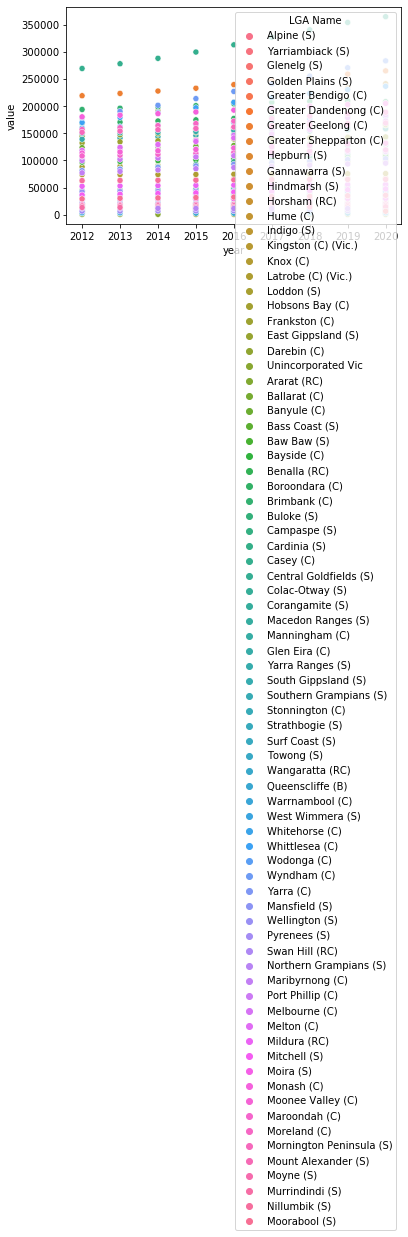

In [7]:
import seaborn as sns

df3 = df2.loc[df2['var'] == 'Estimated resident population']

sns.scatterplot(data = df3, x='year', y='value', hue='LGA Name')

In [8]:
# Forecasting population

df3.groupby(['LGA Code', 'LGA Name'])['value'].apply(pd.Series.pct_change)

0            NaN
78           NaN
22           NaN
23           NaN
24           NaN
          ...   
1445    0.012658
1446    0.004424
1447    0.006384
1448    0.001843
1470   -0.007383
Name: value, Length: 720, dtype: float64

# age_sex -

- Contains information about the estimated resident population, binned by ages
- 1st sheet males
- 2nd sheet females
- 3rd sheet combined
- Seperated by SA2, not LGA
- Sheets are not seperated by state, so will need to read all of them in and retain only VIC

In [9]:
df = pd.read_excel('../data/raw/abs_data/pop_deaths.xlsx', sheet_name = 2, skiprows = 4, header = [0,1], nrows = 129)[1:]

In [10]:
male_age = pd.read_excel('../data/raw/abs_data/age_sex.xlsx', sheet_name = 1, skiprows = 4, header = [0,1], nrows = 18692)[1:]
female_age = pd.read_excel('../data/raw/abs_data/age_sex.xlsx', sheet_name = 2, skiprows = 4, header = [0,1], nrows = 18692)[1:]
total_age = pd.read_excel('../data/raw/abs_data/age_sex.xlsx', sheet_name = 3, skiprows = 4, header = [0,1], nrows = 18692)[1:]

In [11]:
male_columns = ['S/T code', 'S/T name', 'GCCSA code', 'GCCSA name', 'SA4 code', 'SA4 name', 'SA3 code', 'SA3 name', 'SA2 code', 'SA2 name', \
          '0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', \
          '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85 and over', 'Total males']

female_columns = ['S/T code', 'S/T name', 'GCCSA code', 'GCCSA name', 'SA4 code', 'SA4 name', 'SA3 code', 'SA3 name', 'SA2 code', 'SA2 name', \
          '0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', \
          '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85 and over', 'Total females']

total_columns = ['S/T code', 'S/T name', 'GCCSA code', 'GCCSA name', 'SA4 code', 'SA4 name', 'SA3 code', 'SA3 name', 'SA2 code', 'SA2 name', \
          '0-4', '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44', '45-49', '50-54', \
          '55-59', '60-64', '65-69', '70-74', '75-79', '80-84', '85 and over', 'Total persons']

In [12]:
male_age.columns = male_columns
male_age.drop(male_age.index[[0,1]], inplace = True)
#male_age.dropna(inplace = True)

female_age.columns = female_columns
female_age.drop(female_age.index[[0,1]], inplace = True)
#female_age.dropna(inplace = True)

total_age.columns = total_columns
total_age.drop(total_age.index[[0,1]], inplace = True)
#total_age.dropna(inplace = True)

In [13]:
male_vic = male_age.loc[male_age['S/T name'] == 'Victoria']
female_vic = female_age.loc[female_age['S/T name'] == 'Victoria']
total_vic = total_age.loc[total_age['S/T name'] == 'Victoria']

In [21]:
total_vic.columns

Index(['S/T code', 'S/T name', 'GCCSA code', 'GCCSA name', 'SA4 code',
       'SA4 name', 'SA3 code', 'SA3 name', 'SA2 code', 'SA2 name', '0-4',
       '5-9', '10-14', '15-19', '20-24', '25-29', '30-34', '35-39', '40-44',
       '45-49', '50-54', '55-59', '60-64', '65-69', '70-74', '75-79', '80-84',
       '85 and over', 'Total persons'],
      dtype='object')

In [20]:
total_vic.head()

,S/T code,S/T name,GCCSA code,GCCSA name,SA4 code,SA4 name,SA3 code,SA3 name,SA2 code,SA2 name,...,45-49,50-54,55-59,60-64,65-69,70-74,75-79,80-84,85 and over,Total persons
648,2,Victoria,2RVIC,Rest of Vic.,201,Ballarat,20101,Ballarat,201011001,Alfredton,...,1142,974,848,709,666,596,419,253,164,16823
649,2,Victoria,2RVIC,Rest of Vic.,201,Ballarat,20101,Ballarat,201011002,Ballarat,...,818,833,812,822,721,736,526,387,380,12076
650,2,Victoria,2RVIC,Rest of Vic.,201,Ballarat,20101,Ballarat,201011005,Buninyong,...,532,495,452,526,474,398,204,134,85,7232
651,2,Victoria,2RVIC,Rest of Vic.,201,Ballarat,20101,Ballarat,201011006,Delacombe,...,565,530,538,479,428,432,280,175,228,10640
652,2,Victoria,2RVIC,Rest of Vic.,201,Ballarat,20101,Ballarat,201011007,Smythes Creek,...,326,344,312,311,242,186,95,40,31,4213


# education

In [14]:
df = pd.read_excel('../data/raw/abs_data/education.xlsx', sheet_name = 3, skiprows = 4)

In [16]:
vic_education = df.loc[df['State/Territory'] == 'b Vic.']

In [17]:
vic_education.head(10)

,Year,State/Territory,Affiliation (Gov/Non-gov),Affiliation (Gov/Cath/Ind),School Type,School Count
12,2021,b Vic.,a Government,a Government,a Primary school,1137.0
13,2021,b Vic.,a Government,a Government,b Secondary school,247.0
14,2021,b Vic.,a Government,a Government,c Combined school,82.0
15,2021,b Vic.,a Government,a Government,d Special school,81.0
16,2021,b Vic.,b Non-Government,b Catholic,a Primary school,394.0
...,...,...,...,...,...,...
1045,2010,b Vic.,b Non-Government,b Catholic,d Special school,8.0
1046,2010,b Vic.,b Non-Government,c Independent,a Primary school,46.0
1047,2010,b Vic.,b Non-Government,c Independent,b Secondary school,15.0
1048,2010,b Vic.,b Non-Government,c Independent,c Combined school,140.0


## Have change in school (type) distribution over 11 years

In [18]:
vic_education['Year'].value_counts()

2021    12
2020    12
2019    12
2018    12
2017    12
2016    12
2015    12
2014    12
2013    12
2012    12
2011    12
2010    12
Name: Year, dtype: int64

In [19]:
vic_education.shape

(144, 6)

# Schools data - 
- https://discover.data.vic.gov.au/dataset/school-locations-time-series
- https://discover.data.vic.gov.au/dataset/school-locations-2020
- https://discover.data.vic.gov.au/dataset/school-locations-2021/resource/97c05fd1-8671-4f0a-9f91-e8d57a1c1135
- https://discover.data.vic.gov.au/dataset/school-locations-2022